# Layers

> Functional layers that are trainable with backpropagation.

In [ ]:
#| default_exp layers

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| export
import numpy as np
import tensorflow as tf

In [ ]:
#| hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

## Gabor layer

> Convolutional layer that forces a functional Gabor form for its filters. Every parameter of the Gabor can be learnt.

## Managing `dtype`

`Tensorflow` is a bit picky when it comes to `dtype`, so it can be useful to define a function that will ensure that every parameter is casted to the same `dtype`:

In [ ]:
#| exporti
def cast_all(*args, dtype=tf.float32):
    return [tf.cast(arg, dtype=dtype) for arg in args]

In [ ]:
a, b = tf.convert_to_tensor(1), tf.convert_to_tensor(1.1)
print(a.dtype, b.dtype)
# assert a.dtype != b.dtype

<dtype: 'int32'>Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

 <dtype: 'float32'>


2022-09-05 12:12:09.182081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-05 12:12:09.182479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
c, d = cast_all(a, b)
print(c.dtype, d.dtype)
assert c.dtype == d.dtype

<dtype: 'float32'> <dtype: 'float32'>


## Creating a Gabor filter in `TensorFlow`

First of all we need to be able to generate Gabor filters as `Tensorflow` `Tensor`:

In [ ]:
#| export
@tf.function
def gabor_2d_tf(i, # Horizontal domain
                j, # Vertical domain
                imean, # Horizontal mean
                jmean, # Vertical mean
                sigma_i, # Horizontal width
                sigma_j, # Vertical width
                freq, # Frecuency of the filter
                theta, # Angle of the filter
                sigma_theta # Width of the angle?? Rotation of the domain??
                ):
    i, j, imean, jmean, sigma_i, sigma_j, freq, theta, sigma_theta, PI = cast_all(i, j, imean, jmean, sigma_i, sigma_j, freq, theta, sigma_theta, np.pi)
    sigma_vector = tf.convert_to_tensor([sigma_i, sigma_j])
    cov_matrix = tf.linalg.diag(sigma_vector)**2
    det_cov_matrix = tf.linalg.det(cov_matrix)
    constant = tf.convert_to_tensor((1/(2*PI*tf.sqrt(det_cov_matrix))))
    rotation_matrix = tf.convert_to_tensor([[tf.cos(sigma_theta), -tf.sin(sigma_theta)],
                                            [tf.sin(sigma_theta), tf.cos(sigma_theta)]])
    rotated_covariance = tf.cast(rotation_matrix @ tf.linalg.inv(cov_matrix) @ tf.transpose(rotation_matrix), tf.float32)

    x_r_1 = rotated_covariance[0,0] * i + rotated_covariance[0,1] * j
    y_r_1 = rotated_covariance[1,0] * i + rotated_covariance[1,1] * j

    distance = i * x_r_1 + j * y_r_1

    gabor = constant * tf.exp(-distance/2) * tf.cos(2*3.14*freq*(i*tf.cos(theta)+j*tf.sin(theta)))

    return gabor

In [ ]:
#| export
@tf.function
def create_gabor_rot_tf(Nrows, # Number of horizontal pixels
                        Ncols, # Number of vertical pixels
                        imean, # Horizontal mean *(in degrees)*
                        jmean, # Vertical mean *(in degrees)*
                        sigma_i, # Horizontal width *(in degrees)*
                        sigma_j, # Vertical width *(in degrees)*
                        freq, # Frequency
                        theta, # Angle
                        rot_theta, # Rotation of the domain??
                        sigma_theta, # Width of the angle?? Rotation of the domain??
                        fs, # Sampling frequency
                        ):
    """
    Creates a rotated Gabor filter with the input parameters.
    """
    Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs = cast_all(Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs)
    
    x_max = Nrows/fs
    int_x = Ncols/fs
    int_y = Nrows/fs

    Nrows, Ncols = cast_all(Nrows, Ncols, dtype=tf.int32)
    fot_x = tf.linspace(0.0, int_x, Nrows+1)[:-1]
    fot_y = tf.linspace(0.0, int_y, Ncols+1)[:-1]
    x, y = tf.meshgrid(fot_x, fot_y, indexing='xy')

    x_r = tf.cos(rot_theta) * (x - imean) - tf.sin(rot_theta) * (y - jmean)
    y_r = tf.sin(rot_theta) * (x - imean) + tf.cos(rot_theta) * (y - jmean)

    return gabor_2d_tf(x_r, y_r, imean = imean, jmean = jmean, sigma_i = sigma_i, sigma_j = sigma_j, freq = freq, theta = theta, sigma_theta = sigma_theta)

2022-09-05 12:12:09.647925: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-05 12:12:09.651383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


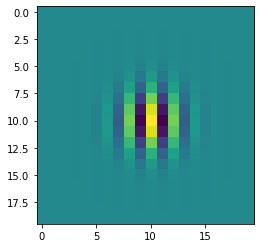

In [ ]:
gabor = create_gabor_rot_tf(Nrows=20, Ncols=20, imean=0.5, jmean=0.5, sigma_i=0.1, sigma_j=0.1, freq=10, theta=0, rot_theta=0, sigma_theta=0, fs=20)
plt.imshow(gabor)
plt.show()

## Creating a set of Gabor filters

> It can be a little bit tricky to translate plain Python `for` loops into `tf.function`.

In plain Python, if we wanted to create a set of filters we could initialize an empty array or list and fill it with the different filters generated inside a `for` loop, but we can't do that inside a `tf.function` because `Tensorflow` tries to build the computational graph and starts to nest graphs inside graphs and the performance is terrible. Luckily for us, they implement a `tf.TensorArray` that can be used inside a `tf.function` to this effect.

In [ ]:
#| export
@tf.function
def create_multiple_different_rot_gabor_tf(n_gabors, # Number of Gabor filters we want to create.
                                           Nrows, # Number of horizontal pixels.
                                           Ncols, # Number of vertical pixels.
                                           imean, # Horizontal mean *(in degrees)*.
                                           jmean, # Vertical mean *(in degrees)*.
                                           sigma_i: list, # Horizontal width *(in degrees)*.
                                           sigma_j: list, # Vertical width *(in degrees)*.
                                           freq: list, # Frequency.
                                           theta: list, # Angle.
                                           rot_theta: list, # Rotation of the domain??
                                           sigma_theta: list, # Width of the angle?? Rotation of the domain??
                                           fs, # Sampling frequency.
                                           ):
    """
    Creates a set of Gabor filters.
    """
    Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs = cast_all(Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs)
    gabors = tf.TensorArray(dtype = tf.float32, size = n_gabors)

    for n in tf.range(start = 0, limit = n_gabors, dtype = tf.int32):
        gabors = gabors.write(n, create_gabor_rot_tf(Nrows, Ncols, imean, jmean, tf.gather(sigma_i, n), tf.gather(sigma_j, n), tf.gather(freq, n), tf.gather(theta, n), 
                                                     tf.gather(rot_theta, n), tf.gather(sigma_theta, n), fs))

    gabors = gabors.stack()
    # gabors = tf.expand_dims(gabors, axis = -1)
    # gabors = tf.transpose(gabors, perm = [1,2,3,0])
    return gabors

In [ ]:
n_gabors = 4
gabors = create_multiple_different_rot_gabor_tf(n_gabors=n_gabors, Nrows=20, Ncols=20, imean=0.5, jmean=0.5, sigma_i=[0.1]*n_gabors, sigma_j=[0.1]*n_gabors, freq=[10]*n_gabors, 
                                                theta=[0]*n_gabors, rot_theta=[0]*n_gabors, sigma_theta=[0]*n_gabors, fs=20)
gabors.shape

2022-09-05 12:12:09.987560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


TensorShape([4, 20, 20])

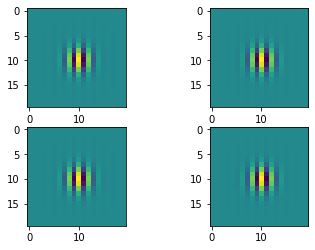

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for gabor_filter, ax in zip(gabors, axes.ravel()):
    ax.imshow(gabor_filter)
plt.show()

We can, as well, change the parameters of the Gabor filters independently:

In [ ]:
n_gabors = 4
sigma_i = [0.1, 0.2, 0.3, 0.4]
sigma_j = [0.1, 0.2, 0.3, 0.4]
freq = [10, 20, 30, 40]
theta = [0, 45, 90, 135]
rot_theta = [0, 45, 90, 135]
sigma_theta = [0, 45, 90, 135]
gabors = create_multiple_different_rot_gabor_tf(n_gabors=n_gabors, Nrows=20, Ncols=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                                                theta=theta, rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20)
gabors.shape

2022-09-05 12:12:10.600241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


TensorShape([4, 20, 20])

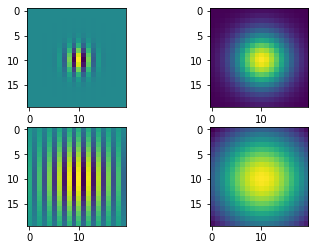

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for gabor_filter, ax in zip(gabors, axes.ravel()):
    ax.imshow(gabor_filter)
plt.show()

## Random initialize a set of Gabor filters

> Insted of defining ourselves the initial values, we can randomly initialize them. This can speed up our testing.

In [ ]:
#| export
@tf.function
def create_multiple_random_rot_gabor_tf(n_gabors, # Number of Gabor filters we want to create.
                                           Nrows, # Number of horizontal pixels.
                                           Ncols, # Number of vertical pixels.
                                           imean, # Horizontal mean *(in degrees)*.
                                           jmean, # Vertical mean *(in degrees)*.
                                           sigma_i: list, # Horizontal width *(in degrees)*.
                                           sigma_j: list, # Vertical width *(in degrees)*.
                                           freq: list, # Frequency.
                                           theta: list, # Angle.
                                           rot_theta: list, # Rotation of the domain??
                                           sigma_theta: list, # Width of the angle?? Rotation of the domain??
                                           fs, # Sampling frequency.
                                           ):
    """
    Creates a set of Gabor filters.
    """
    sigma_i = np.random.uniform(0, Nrows/fs)
    sigma_j = np.random.uniform(0, Ncols/fs)
    Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs = cast_all(Nrows, Ncols, imean, jmean, sigma_i, sigma_j, freq, theta, rot_theta, sigma_theta, fs)
    gabors = tf.TensorArray(dtype = tf.float32, size = n_gabors)

    for n in tf.range(start = 0, limit = n_gabors, dtype = tf.int32):
        gabors = gabors.write(n, create_gabor_rot_tf(Nrows, Ncols, imean, jmean, tf.gather(sigma_i, n), tf.gather(sigma_j, n), tf.gather(freq, n), tf.gather(theta, n), 
                                                     tf.gather(rot_theta, n), tf.gather(sigma_theta, n), fs))

    gabors = gabors.stack()
    # gabors = tf.expand_dims(gabors, axis = -1)
    # gabors = tf.transpose(gabors, perm = [1,2,3,0])
    return gabors